# Modelling and Evaluating Cherry Leaf Images

## Objectives

* Build, train, and evaluate a Convolutional Neural Network (CNN) model to classify cherry leaf images as healthy or powdery mildew.
* Achieve a classification accuracy of at least 97% on unseen test data.
* Fulfill the client's need to automatically identify cherry leaves with powdery mildew.

## Inputs

* **Data:**
    * Training, validation, and test datasets located in `data/cherry-leaves/train`, `data/cherry-leaves/validation`, and `data/cherry-leaves/test` respectively.
    * Images are in JPG format and have been resized to 100x100 pixels.
* **Image Shape Embeddings

## Outputs

* **Model:** Trained CNN model saved in Keras format (`cherry_leaves_model.keras`).
* **Evaluation Metrics:** Pickle file (`evaluation_results.pkl`) containing:
    * Test accuracy
    * Classification report (precision, recall, F1-score)
    * Confusion matrix
* **Visualizations:**
    * PNG image (`labels_distribution.png`) showing the distribution of images in train, validation, and test sets.
    * PNG image (`learning_curves.png`) displaying the learning curves of the model during training.
* **Prediction:** Prediction results on a random image file, including predicted class and probability.

In [1]:
# Set Data Directory

## Import Libraries

import tensorflow as tf
import os
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix

2025-02-20 18:18:55.698457: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 18:18:55.733730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set Random Seed for Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# 1. Project Directory and Data Paths
PROJECT_DIR = os.path.dirname(os.getcwd())  
DATA_DIR = os.path.join(PROJECT_DIR, "data", "cherry-leaves")

# Determine the next version number
existing_versions = [
    int(v[1:]) for v in os.listdir(os.path.join(PROJECT_DIR, "outputs")) if v.startswith("v")
]
next_version = f"v{max(existing_versions) + 1}" if existing_versions else "v1"

OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs", next_version)
os.makedirs(OUTPUT_DIR, exist_ok=True)

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
VAL_DIR = os.path.join(DATA_DIR, "validation")

# Check if the directories exist

if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Test directory not found: {TEST_DIR}")
if not os.path.exists(VAL_DIR):
    raise FileNotFoundError(f"Validation directory not found: {VAL_DIR}")

In [4]:
# 2. Image Dimensions
IMG_WIDTH, IMG_HEIGHT = 100, 100  # Reduced size
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [5]:
# 3. Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Validation: Only Rescaling
test_datagen = ImageDataGenerator(rescale=1./255)  # Test: Only Rescaling

BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=True
)

# Save class indices

with open(os.path.join(OUTPUT_DIR, "class_indices.pkl"), 'wb') as f:
    pickle.dump(train_generator.class_indices, f)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)


Found 2524 images belonging to 2 classes.
Found 840 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


In [6]:
# 4. Model Creation 
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model(INPUT_SHAPE)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729,057 (37.11 MB)

 Trainable params: 9,727,137 (37.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [7]:
# 5. Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    os.path.join(OUTPUT_DIR, "best_model.keras"),
    monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)  # Learning rate reduction

In [8]:
print(f"Train samples: {train_generator.samples}")
print(f"Batch size: {BATCH_SIZE}")

Train samples: 2524
Batch size: 32


In [9]:
# 6. Training
EPOCHS = 15
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9335 - loss: 0.3702
Epoch 1: val_accuracy improved from -inf to 0.84167, saving model to /workspaces/cherry-leaves/outputs/v2/best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9340 - loss: 0.3692 - val_accuracy: 0.8417 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9746 - loss: 0.2468
Epoch 2: val_accuracy did not improve from 0.84167
79/79 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9747 - loss: 0.2464 - val_accuracy: 0.5000 - val_loss: 9.4012 - learning_rate: 0.0010
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9912 - loss: 0.1788
Epoch 3: val_accuracy did not improve from 0.84167
79/79 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9912 - loss: 0.1788 - val_accuracy: 0.5000 - val_loss: 9.4002 - learning_rate: 0.0010
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9893 - loss: 0.1759
Epoch 4: val_accuracy did 

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.9977 - loss: 0.1074
Test Loss: 0.0957
Test Accuracy: 99.88%
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       422
           1       1.00      1.00      1.00       422

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844



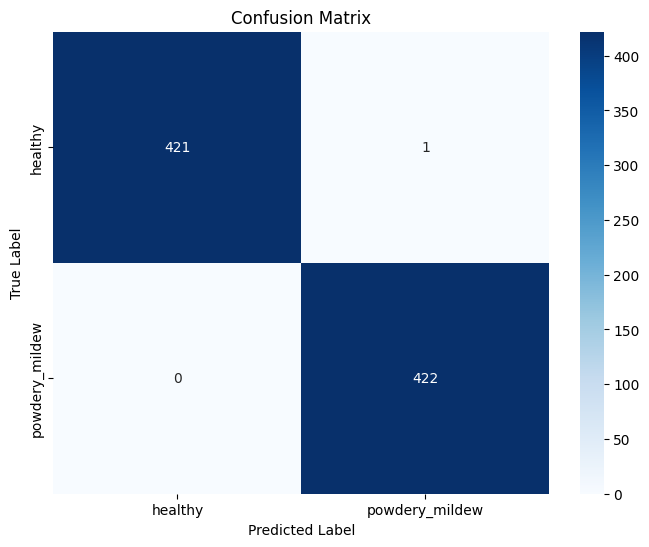

In [13]:
# 7. Model Evaluation and Saving
import math

steps = math.ceil(test_generator.samples / BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_generator, steps=steps)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

y_pred = model.predict(test_generator, steps=steps)

# Determine if it is binary or multiclass
if y_pred.shape[1] > 1:
    y_pred_classes = np.argmax(y_pred, axis=-1)  # Multiclass
else:
    y_pred_classes = (y_pred > 0.5).astype(int)  # Binary

y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes))

cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_generator.class_indices.keys())  # Get class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"))
plt.show()

In [14]:
# Save evaluation metrics and classification report
eval_results = {
    'test_loss': test_loss,
    'test_accuracy': test_accuracy,
    'classification_report': classification_report(y_true, y_pred_classes, output_dict=True) 
}

with open(os.path.join(OUTPUT_DIR, "evaluation_results.pkl"), 'wb') as f:
    pickle.dump(eval_results, f)

Class Indices: {'healthy': 0, 'powdery_mildew': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class: healthy
Probability: 0.0000


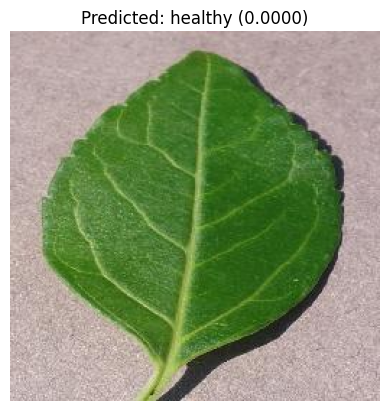

In [15]:
# 8. Prediction on New Data
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array

def predict_on_new_image(image_path, model, class_indices, input_shape):
    try:
        img = load_img(image_path, target_size=input_shape[:2], color_mode='rgb')
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        if img_array.shape[1:] != input_shape:
            raise ValueError("Input image shape does not match model's expected shape.")

        prediction = model.predict(img_array)

        
        if prediction.shape[1] > 1:
          predicted_class_index = np.argmax(prediction)  
        else:
          predicted_class_index = int(round(prediction[0][0])) 
          
        target_map = {v: k for k, v in class_indices.items()}
        predicted_class = target_map[predicted_class_index]
        probability = prediction[0][0] 

        return predicted_class, probability  # Return class and probability

    except FileNotFoundError as e:
        return f"Error: File not found: {e}", None
    except ValueError as e:
        return f"Error: {e}", None
    except Exception as e:
        return f"An error occurred: {e}", None


# Load class indices
with open(os.path.join(OUTPUT_DIR, "class_indices.pkl"), 'rb') as f:
    class_indices = pickle.load(f)

print("Class Indices:", class_indices)  # Print for verification

test_image_paths = glob.glob(os.path.join(TEST_DIR, '*', '*'))  # Get all test image paths

if test_image_paths:  # Check if the list is NOT empty
    random_image_path = np.random.choice(test_image_paths)
    predicted_class, probability = predict_on_new_image(random_image_path, model, class_indices, INPUT_SHAPE)

    if predicted_class:  # Check if prediction was successful (no errors)
        print(f"Predicted Class: {predicted_class}")
        print(f"Probability: {probability:.4f}")

        img = load_img(random_image_path)
        img_array = img_to_array(img)
        plt.imshow(img_array/255.0) #Displaying the image from path directly and correctly
        plt.title(f"Predicted: {predicted_class} ({probability:.4f})")
        plt.axis('off')
        plt.show()
    else:  # Handle prediction errors
        print(predicted_class)  # Print the error message returned by predict_on_new_image

else:  # Handle empty test directory
    print(f"Error: No images found in the test directory: {TEST_DIR}. "
          f"Please check if the directory exists and contains images.")